In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.5


## GPU

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
tf_device='/gpu:3'

## Bibliotecas

In [4]:
# Imports 

# Imports para manipulação e visualização de dados
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os 
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split

# Imports para cálculo de métricas e utilitários
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

# Imports para Deep Learning
#import plaidml
#import plaidml.keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback

# Redes Neurais
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "SINFO" --iversions

Author: SINFO

PIL       : 8.1.2
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
keras     : 2.4.3
tensorflow: 2.4.1
numpy     : 1.19.2
sklearn   : 0.24.1
matplotlib: 3.3.4
pandas    : 1.2.3



## Parâmetros

In [6]:
# Dados de entrada
#PATH_IMAGES = 'dataset/Monkeypox_2_classes/Original_Images/Original_Images/'
PATH_IMAGES = 'dataset/Monkeypox_4_classes/dataset/'

# Parâmetros do treinamento
BATCH_SIZE = 8
SEED = 42

# K-fold
N_SPLIT = 4

In [7]:
# Parâmetros treinamento
epocas_treinamento = 20
base_learning_rate = 0.0001

epocas_ajuste_fino = 10
total_epocas = epocas_treinamento + epocas_ajuste_fino

# Dataset

In [8]:
#CATEGORIAS = ['Monkey Pox', 'Others']
CATEGORIAS = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
NUM_CATEGORIAS = len(CATEGORIAS)
NUM_CATEGORIAS

4

In [9]:
for category in CATEGORIAS:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(PATH_IMAGES, category)))))

Chickenpox 108 images
Measles 91 images
Monkeypox 279 images
Normal 293 images


In [10]:
dataset = []
for category in CATEGORIAS:
    for file in os.listdir(os.path.join(PATH_IMAGES, category)):
        dataset.append(['{}/{}'.format(category, file), category])
dataset = pd.DataFrame(dataset, columns=['arquivo', 'categoria'])
dataset.shape

(771, 2)

In [11]:
dataset

arquivo   categoria
0    Chickenpox/chickenpox49.png  Chickenpox
1    Chickenpox/chickenpox13.png  Chickenpox
2    Chickenpox/chickenpox41.png  Chickenpox
3    Chickenpox/chickenpox61.png  Chickenpox
4    Chickenpox/chickenpox39.png  Chickenpox
..                           ...         ...
766          Normal/normal89.png      Normal
767          Normal/normal47.png      Normal
768          Normal/normal37.png      Normal
769          Normal/normal55.png      Normal
770         Normal/normal290.png      Normal

[771 rows x 2 columns]

In [12]:
# Definindo X e Y
dataset_x = dataset.arquivo
dataset_y = dataset.categoria

# Leitura dos dados

In [13]:
#Initializing Data Generators
datagen = ImageDataGenerator()

# train_datagen = ImageDataGenerator(rescale = 1.0/255,
#                                     zoom_range = 0.2, 
#                                     horizontal_flip = True, 
#                                     vertical_flip = True,
#                                     rotation_range = 90,
#                                     brightness_range = (-0.1, 0.1))

In [14]:
# Carrega os dados de treino, validação e testes
def leitura_dados(img_size):
    train_dataset = datagen.flow_from_dataframe(dataframe = train_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      seed = SEED,
                                                      shuffle = True)

    val_dataset = datagen.flow_from_dataframe(dataframe = val_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      shuffle = False)

    test_dataset = datagen.flow_from_dataframe(dataframe = test_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      shuffle = False)
    
    return train_dataset, val_dataset, test_dataset

# Métricas

In [15]:
# Cria data frame de resultados
# colunas_dataframe = ['model', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'kappa', 'precision', 'fscore', 'specificity', 'sensitivity', 'auc']
# resultados = pd.DataFrame(columns = colunas_dataframe)

def calcula_metricas_binarias(y_true, y_pred):
    
    global resultados
    
    # Cutoff
    y_true = (y_true > 0.5).flatten()
    y_pred = (y_pred > 0.5).flatten()

    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
    kappa = (2 * (tp * tn - fn * fp) / (tp * fn + tp * fp + 2 * tp * tn + fn^2 + fn * fn + fp^2 + fp * tn))
    precision = float(tp)/float(tp + fp)
    fscore = float(2*tp)/float(2*tp + fp + fn)
    specificity = (1.0 * tn) / (tn + fp)
    sensitivity = (1.0 * tp) / (tp + fn)
    auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
    
    resultados = resultados.append({'model': models[rede].name, 
                                    'tp': tp, 
                                    'fp': fp,
                                    'tn': tn,
                                    'fn': fn,
                                    'accuracy': accuracy,
                                    'kappa': kappa,
                                    'precision': precision,
                                    'fscore': fscore,
                                    'specificity': specificity,
                                    'sensitivity': sensitivity,
                                    'auc': auc}, ignore_index=True)

In [16]:
# Cria data frame de resultados
colunas_dataframe = ['model', 'kappa', 'accuracy', 'recall', 'precision', 'f1', 'specificity', 'roc']
resultados = pd.DataFrame(columns = colunas_dataframe)

def metrics_multi_class(y_true, y_pred):
    '''
        fonte: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
    '''
    
    global resultados
    
    cnf_matrix = confusion_matrix(y_true,y_pred)

    fp = (cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)).astype(float)
    fn = (cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)).astype(float)
    tp = (np.diag(cnf_matrix)).astype(float)
    tn = (cnf_matrix.sum() - (fp + fn + tp)).astype(float)
    
    weights = np.sum(cnf_matrix, axis=1)
    specificity_array = (tn / (tn + fp))
    specificity = np.sum(specificity_array * weights) / np.sum(weights)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted') # sensibility
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # ROC
    lb = LabelBinarizer()
    lb.fit(y_true)
    true = lb.transform(y_true)
    pred = lb.transform(y_pred)
    roc = roc_auc_score(true, pred)
    
    metricas = {'model': models[rede].name, 
                'kappa': kappa,
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'specificity':specificity,
                'roc': roc}
    
    print(metricas)
    
    resultados = resultados.append(metricas, ignore_index=True)
    
    return kappa

In [17]:
import itertools

# Função para a Matriz de Confusão
def plot_confusion_matrix(normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues):
    
    classes = CATEGORIAS
    cm = confusion_matrix(y_true, y_pred)
    
    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    #print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()
    plt.show()

# Modelo

In [18]:
# leitura dos pesos pré-treinados da ImageNet
# Não inclui as camadas de classificação no topo, ideal para extração de features
models = [
    VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    DenseNet201(weights = "imagenet", input_shape = (224, 224, 3), include_top = False),
    InceptionV3(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    NASNetLarge(weights='imagenet', input_shape=(331, 331, 3), include_top=False),
    ResNet152V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
]

# Reescala dos valores dos pixels do modelo
processamento_input = [
    keras.applications.vgg16.preprocess_input,
    keras.applications.densenet.preprocess_input,
    keras.applications.inception_v3.preprocess_input,
    keras.applications.xception.preprocess_input,
    keras.applications.inception_resnet_v2.preprocess_input,
    keras.applications.nasnet.preprocess_input,
    keras.applications.resnet_v2.preprocess_input
]

In [19]:
# Construir um modelo a partir de redes neurais pré-treinadas
def modelo_base(rede):
    
    base_model = models[rede]
    img_size = (base_model.input.shape[1], base_model.input.shape[2])
    
    # Processa as entradas do modelo
    preprocess_input = processamento_input[rede]
    
    return base_model, img_size, preprocess_input

In [20]:
# Usando aumento de dados aleatórios somente no fit (treinamento)
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        # keras.layers.experimental.preprocessing.RandomRotation(0.1), # retirar por conta dos cantos pretos
        keras.layers.experimental.preprocessing.RandomZoom(0.1),
        keras.layers.experimental.preprocessing.RandomContrast(0.2)
    ]
)

In [21]:
# Construir modelo
def build_model():
    
    # Freeze the base_model
    # Congela a base convolucional antes de compilar e treinar o modelo
    # Evita que os pesos em uma determinada camada sejam atualizados durante o treinamento
    base_model.trainable = False
    
    # Arquitetura do modelo básico
    # base_model.summary()

    # Adiciona o cabeçalho de classificação
    # Converter as features do shape `base_model.output_shape[1:] para vectores
    global_average_layer = keras.layers.GlobalAveragePooling2D()

    # Aplica uma camada densa para converter essas features em uma única previsão por imagem
    # Os números > 0.5 preveem a classe 1, os números <= 0.5 preveem a classe 0
    prediction_layer = keras.layers.Dense(4, activation="softmax", name='predictions') # Função de ativação sigmoid adicionada

    # Modelo encadeando as camadas de aumento de dados, reescalonamento, base_model e extrator de features
    img_shape = img_size + (3,)
    inputs = keras.Input(shape = img_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = keras.Model(inputs, outputs)  
    
    return model

In [22]:
# Compile o modelo antes de treiná-lo
def compile_model(learning_rate):
    
    # Compilar modelo
    # Não especifiquei o batch_size, pois os dados já estão em conjuntos (batchs)
    model.compile(optimizer = Adam(lr = learning_rate), loss = keras.losses.CategoricalCrossentropy(), metrics = ['categorical_accuracy'])
    
    # model.summary()

In [23]:
# Definimos um checkpoint para verificar regularmente se a perda em validação diminuiu
# Se a performance melhorar em validação salvamos o modelo
# Podemos ainda optar por salvar o modelo a cada número de épocas
# callbacks
# Redução gradual da taxa de aprendizado (Reduce on Plateau)
def get_callbacks():
    return [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
            ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.0000001, verbose = 1),
            ModelCheckpoint('modelo/{}.h5'.format(models[rede].name), 
                         verbose = 1, 
                         save_best_only = True, 
                         save_weights_only = True)]

In [24]:
# Treinamento do modelo
def treinamento_model(qnt_epocas, epoca_inicial):
    
    history = model.fit(train_dataset,
                        epochs = qnt_epocas,
                        initial_epoch = epoca_inicial,
                        validation_data = val_dataset,
                        verbose=1,
                        callbacks = get_callbacks())
    
    return history

In [25]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
def aprendizado_treinamento():
    
    metricas_graficos = ["loss", "categorical_accuracy"]
          
    fig, ax = plt.subplots(len(metricas_graficos), 1, figsize=(10, len(metricas_graficos)*6))
    ax = ax.ravel()
    dados_x = np.arange(1, epocas_treinamento+1, 1)

    for i, met in enumerate(metricas_graficos):        
        ax[i].plot(dados_x, history.history[met], label='Training ' + met)
        ax[i].plot(dados_x, history.history["val_" + met], label='Validation ' + met)
        ax[i].set_title("Training and Validation %s in model %s" %(met, models[rede].name))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        
        if (i != 0): # loss function
            ax[i].legend(loc='lower right')
        else:
            ax[i].legend(loc='upper right')
    
    return metricas_graficos

In [26]:
# LIMIAR PARA AJUSTE FINO (OPCIONAL)
# Definir as camadas inferiores como não treináveis
def limiar_ajuste_fino():
    
    # Exibe a quantidade de camadas do modelo base
    # print("Número de camadas no modelo base: ", len(base_model.layers))

    # Ajuste fino desta camada em diante
    fine_tune_at = 100

    # Congele todas as camadas antes da camada 'fine_tune_at'
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

In [27]:
# Ajuste fino
def ajuste_fino():
    
    # Foi treinado apenas algumas camadas do modelo. 
    # Os pesos da rede pré-treinada não foram atualizados durante o treinamento.
    # Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores 
    # do modelo pré-treinado junto com o treinamento do classificador adicionado (camada de classificação adicionada)
    # Descongelar as camadas superiores do modelo (descongelar base_model)
    base_model.trainable = True
    
    # Limiar ajuste fino (OPCIONAL)
    limiar_ajuste_fino()
    
    # É necessário recompilar o modelo (para que essas alterações tenham efeito)
    # É importante usar uma taxa de aprendizado mais baixa neste estágio, 
    # pois está usando um modelo muito maior e deseja readaptar os pesos pré-treinados
    compile_model(base_learning_rate/10)
    
    # Retomar o treinamento melhorará sua precisão em alguns pontos percentuais
    # history.epoch[-1] é a última época do ultimo treinamento
    history_fine = treinamento_model(total_epocas, history.epoch[-1]+1)
    
    return history_fine

In [28]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao ajustar as últimas camadas do modelo
def aprendizado_ajuste_fino():
    
    fig, ax = plt.subplots(len(metricas_graficos), 1, figsize=(12, len(metricas_graficos)*6))
    ax = ax.ravel()
    dados_x = np.arange(1, len(history.history['loss']) + len(history_fine.history['loss'])+1, 1)

    for i, met in enumerate(metricas_graficos):
        dados_treino = history.history[met] + history_fine.history[met]
        dados_validacao = history.history["val_" + met] + history_fine.history["val_" + met]
        
        ax[i].plot(dados_x, dados_treino, label='Training ' + met)
        ax[i].plot(dados_x, dados_validacao, label='Validation ' + met)
        ax[i].plot([epocas_treinamento, epocas_treinamento], plt.ylim(), label='Start Fine Tuning')
        ax[i].set_title("Training and Validation %s in model %s" %(met, models[rede].name))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        
        if (i != 0): # loss function
            ax[i].legend(loc='lower right')
        else:
            ax[i].legend(loc='upper right')

# Treinamento K-fold

In [29]:
# k-fold
kfold = StratifiedKFold(n_splits = N_SPLIT, shuffle = True, random_state = SEED)

# Contador de iterações do k-fold
iteracao = 1

# K-fold treino e teste de cada divisão
for train_idx, test_idx in list(kfold.split(dataset_x, dataset_y)):
    
    print("\n======================================================")
    print("Iteração {} de {}".format(iteracao, N_SPLIT))
    print("======================================================")
    
    train_df = dataset.iloc[train_idx]
    test_temp = dataset.iloc[test_idx]
    
    # dividir o teste em validação e teste
    val_df, test_df = train_test_split(test_temp, test_size = 0.60, random_state = SEED) # 10% validação e 15% teste
    
    #for rede in range(len(models)): # Todos os modelos
    rede = 1

    print('\nExecutando modelo {}'.format(models[rede].name))

    # Modelo base
    base_model, img_size, preprocess_input = modelo_base(rede)

    # Leitura dos dados
    train_dataset, val_dataset, test_dataset = leitura_dados(img_size)

    # Construir modelo
    model = build_model()

    # Compilar Modelo
    compile_model(base_learning_rate)

    # Treinamento do modelo
    history = treinamento_model(epocas_treinamento, 0)

    # Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
    # metricas_graficos = aprendizado_treinamento()

    # Ajuste fino
    history_fine = ajuste_fino()

    # Curvas de aprendizado da precisão / perda de treinamento e validação ao ajustar as últimas camadas do modelo
    # aprendizado_ajuste_fino()

    # Carrega o melhor modelo
    model.load_weights('modelo/{}.h5'.format(models[rede].name))

    # Obtemos os rótulos verdadeiros
    y_true = np.array(test_dataset.classes)

    # Obtemos os rótulos previstos
    previsoes = model.predict(test_dataset, verbose = 1)
    y_pred = previsoes.argmax(axis=1)

    # Calcula métricas Multiclasse
    kappa = metrics_multi_class(y_true, y_pred)
    
    if (kappa > 0.98):
        break

    # Plota matriz de confusão
    # plot_confusion_matrix()

    # Gera o relatório de classificação
    # report = classification_report(y_true, y_pred, target_names = CATEGORIAS)
    # print(report)

    # Limpa a sessão
    keras.backend.clear_session()
        
    iteracao = iteracao + 1


Iteração 1 de 4

Executando modelo densenet201
Found 577 validated image filenames belonging to 4 classes.
Found 77 validated image filenames belonging to 4 classes.
Found 116 validated image filenames belonging to 4 classes.
Epoch 1/20
73/73 [==============================] - 194s 2s/step - loss: 1.2982 - categorical_accuracy: 0.4214 - val_loss: 0.9905 - val_categorical_accuracy: 0.6234

Epoch 00001: val_loss improved from inf to 0.99054, saving model to modelo/densenet201.h5
Epoch 2/20
73/73 [==============================] - 3s 34ms/step - loss: 0.9931 - categorical_accuracy: 0.6000 - val_loss: 0.8480 - val_categorical_accuracy: 0.6883

Epoch 00002: val_loss improved from 0.99054 to 0.84796, saving model to modelo/densenet201.h5
Epoch 3/20
73/73 [==============================] - 2s 33ms/step - loss: 0.9478 - categorical_accuracy: 0.6164 - val_loss: 0.7431 - val_categorical_accuracy: 0.7403

Epoch 00003: val_loss improved from 0.84796 to 0.74311, saving model to modelo/densenet201.

In [30]:
resultados

model     kappa  accuracy    recall  precision        f1  \
0  densenet201  0.913956  0.939655  0.939655   0.939881  0.938920   
1  densenet201  0.890047  0.922414  0.922414   0.924900  0.922440   
2  densenet201  0.975450  0.982759  0.982759   0.983171  0.982356   
3  densenet201  0.987605  0.991304  0.991304   0.991527  0.991221   

   specificity       roc  
0     0.974494  0.946400  
1     0.971735  0.938384  
2     0.990532  0.982772  
3     0.995709  0.990564

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0     

In [32]:
model.get_layer("densenet201").summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [33]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
	def __init__(self, model, classIdx, inner_model=None, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.inner_model = inner_model
		if self.inner_model == None:
			self.inner_model = model
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()
            
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(inputs=[self.inner_model.inputs], outputs=[self.inner_model.get_layer(self.layerName).output, self.inner_model.output])
        
		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)
        
		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]
        
		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)


In [126]:
import cv2

model_layer = "densenet201"
#last_conv_layer_name = "pool4_conv" # Essa camada é a úlima camada Conv2D de tamanho 14 pixels
last_conv_layer_name = "pool4_conv"
cam = GradCAM(model, None, inner_model=model.get_layer(model_layer), layerName=last_conv_layer_name)

def grad_cam_teste():

    image_batch, label_batch = test_dataset.next()
    predictions = model.predict(image_batch) # retirei o flatten

    predictions = predictions.argmax(axis=1)
    label_batch = label_batch.argmax(axis=1)
    classes = ['Catapora', 'Sarampo', 'Variola dos Macacos', 'Normal']

    print('Predictions:\n', predictions)
    print('Labels:\n', label_batch)

    plt.figure(figsize=(40, 80))
    for i in range(8):        
        image = image_batch[i].astype("uint8")
        image_cv2 = cv2.resize(image, img_size)
        
        image = np.expand_dims(image, axis=0)
        label = classes[predictions[i]]
        
        # load the input image from disk (in Keras/TensorFlow format) and
        # preprocess it
        heatmap = cam.compute_heatmap(image)
        # resize the resulting heatmap to the original input image dimensions
        # and then overlay heatmap on top of the image
        heatmap = cv2.resize(heatmap, img_size)
        (heatmap, output) = cam.overlay_heatmap(heatmap, image_cv2, alpha=0.5)

        # draw the predicted label on the output image
        # cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
        cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        # display the original image and resulting heatmap and output image

        # to our screen
        output = np.hstack([image_cv2, heatmap, output])
        # cv2.imshow("Output", output)
        # cv2.waitKey(0)
        
        ax = plt.subplot(8, 1, i + 1)
        plt.imshow(output)
        # plt.imshow(output, cmap='jet', alpha=0.5)
        plt.axis("off")

Predictions:
 [2 3 1 3 1 3 2 2]
Labels:
 [2 3 1 3 1 3 2 2]


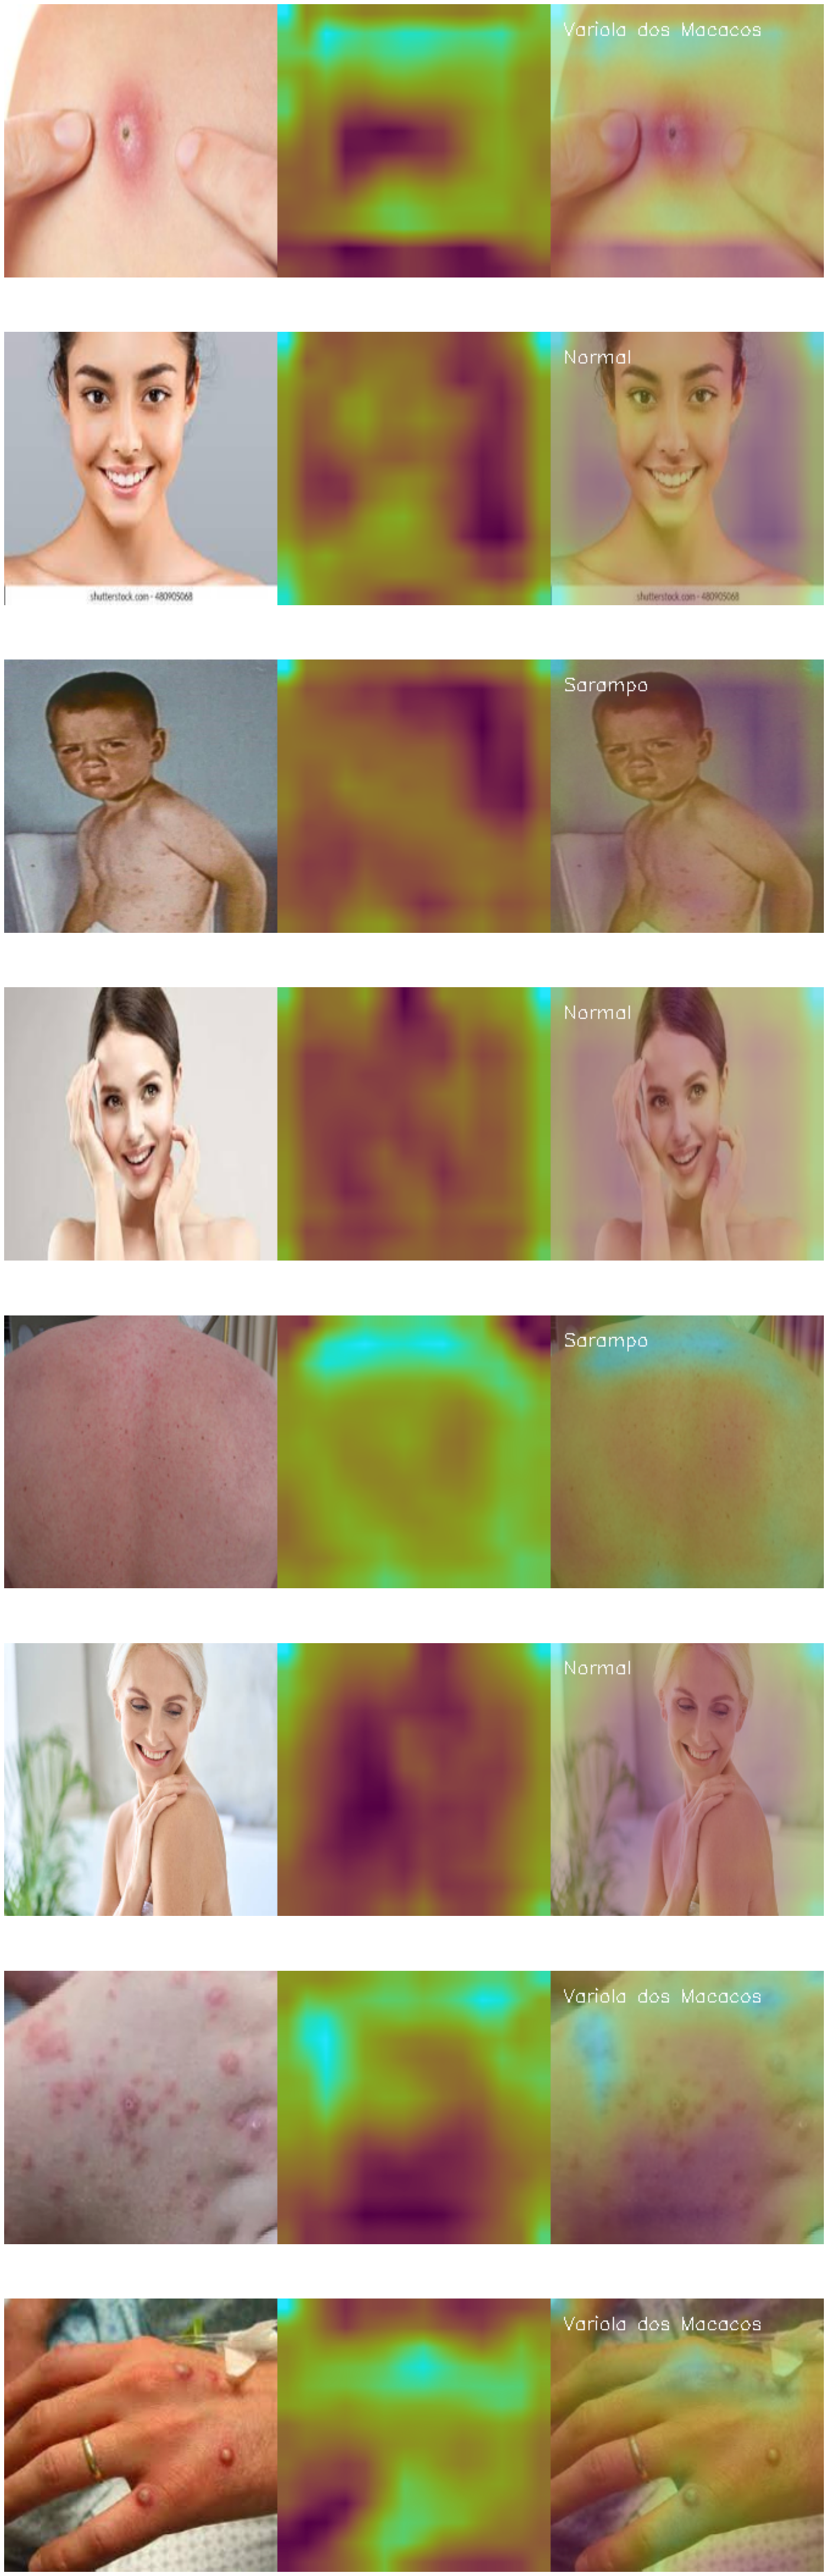

In [130]:
grad_cam_teste()